In [2]:
# Importar bibliotecas necess√°rias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# üìå Carregar os arquivos necess√°rios
admissions_df = pd.read_csv("admissions.csv")
icustays_df = pd.read_csv("icustays.csv")
patients_df = pd.read_csv("patients.csv")
diagnoses_df = pd.read_csv("diagnoses_icd.csv")  # Diagn√≥sticos dos pacientes
icd_descriptions_df = pd.read_csv("d_icd_diagnoses.csv")  # Descri√ß√£o dos diagn√≥sticos

# üìå Converter colunas de tempo para datetime
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

# üìå Calcular tempo de interna√ß√£o
admissions_df['hospital_los'] = (admissions_df['dischtime'] - admissions_df['admittime']).dt.total_seconds() / (24 * 3600)
icustays_df['icu_los'] = (icustays_df['outtime'] - icustays_df['intime']).dt.total_seconds() / (24 * 3600)

# üìå Filtrar apenas os pacientes que foram para a UTI
pacientes_uti = admissions_df.merge(icustays_df[['subject_id', 'stay_id', 'icu_los']], on="subject_id", how="inner")

# üìå Unir dados da UTI com a informa√ß√£o de mortalidade
mortalidade_uti = pacientes_uti[['subject_id', 'hospital_expire_flag', 'icu_los']]
mortalidade_uti_corrigida = pacientes_uti[['subject_id', 'hospital_expire_flag']].drop_duplicates()

# üìå Estat√≠sticas gerais
total_pacientes_uti = pacientes_uti['subject_id'].nunique()
num_obitos_uti = mortalidade_uti_corrigida[mortalidade_uti_corrigida['hospital_expire_flag'] == 1]['subject_id'].nunique()
num_sobreviventes_uti = total_pacientes_uti - num_obitos_uti
taxa_mortalidade_uti = (num_obitos_uti / total_pacientes_uti) * 100
tempo_medio_uti = icustays_df['icu_los'].mean()

# üìå Distribui√ß√£o de G√™nero (Corrigida para exibi√ß√£o correta)
genero_contagem = patients_df['gender'].value_counts().to_dict()

# üìå Exibir estat√≠sticas no terminal
print("\nüìä Estat√≠sticas Gerais dos Pacientes na UTI:")
print(f"‚Ä¢ Total de Pacientes na UTI: {total_pacientes_uti}")
print(f"‚Ä¢ Pacientes que sobreviveram: {num_sobreviventes_uti}")
print(f"‚Ä¢ Pacientes que faleceram na UTI: {num_obitos_uti}")
print(f"‚Ä¢ Taxa de Mortalidade na UTI: {taxa_mortalidade_uti:.2f}%")
print(f"‚Ä¢ Tempo m√©dio de interna√ß√£o na UTI: {tempo_medio_uti:.2f} dias\n")

print("üìä Distribui√ß√£o de G√™nero:")
for genero, contagem in genero_contagem.items():
    print(f"‚Ä¢ {genero}: {contagem} pacientes")
    
# üìå Filtrar apenas os diagn√≥sticos dos pacientes que foram para a UTI
diagnoses_uti = diagnoses_df.merge(pacientes_uti[['subject_id']], on="subject_id", how="inner")

# üìå Contar o n√∫mero de pacientes √∫nicos para cada diagn√≥stico na UTI
diagnosticos_uti_corrigido = diagnoses_uti.groupby("icd_code")["subject_id"].nunique().reset_index()
diagnosticos_uti_corrigido.columns = ["C√≥digo ICD", "N√∫mero de Pacientes"]

# üìå Unir com as descri√ß√µes dos diagn√≥sticos
diagnosticos_uti_corrigido = diagnosticos_uti_corrigido.merge(
    icd_descriptions_df[['icd_code', 'long_title']], left_on="C√≥digo ICD", right_on="icd_code", how="left"
).drop(columns=["icd_code"])  # Remover duplicata da coluna ICD

# üìå Renomear coluna de descri√ß√£o do diagn√≥stico
diagnosticos_uti_corrigido = diagnosticos_uti_corrigido.rename(columns={"long_title": "Descri√ß√£o do Diagn√≥stico"})

# üìå Ordenar pelos diagn√≥sticos mais frequentes
diagnosticos_uti_corrigido = diagnosticos_uti_corrigido.sort_values(by="N√∫mero de Pacientes", ascending=False).head(10)
diagnosticos_uti_corrigido = diagnosticos_uti_corrigido.reset_index(drop=True)

# üìå Exibir os resultados corrigidos
from IPython.display import display

print("\nüìä Top 10 Diagn√≥sticos Mais Frequentes na UTI (N√∫mero de Pacientes √önicos)\n")
display(diagnosticos_uti_corrigido)

# üìå Salvar a tabela para uso futuro
diagnosticos_uti_corrigido.to_csv("diagnosticos_uti.csv", index=False)


üìä Estat√≠sticas Gerais dos Pacientes na UTI:
‚Ä¢ Total de Pacientes na UTI: 100
‚Ä¢ Pacientes que sobreviveram: 85
‚Ä¢ Pacientes que faleceram na UTI: 15
‚Ä¢ Taxa de Mortalidade na UTI: 15.00%
‚Ä¢ Tempo m√©dio de interna√ß√£o na UTI: 3.68 dias

üìä Distribui√ß√£o de G√™nero:
‚Ä¢ M: 57 pacientes
‚Ä¢ F: 43 pacientes

üìä Top 10 Diagn√≥sticos Mais Frequentes na UTI (N√∫mero de Pacientes √önicos)



C√≥digo ICD  N√∫mero de Pacientes  \
0       4019                   41   
1       2724                   34   
2       E785                   21   
3      25000                   21   
4      V1582                   20   
5      41401                   19   
6       3051                   18   
7       2859                   18   
8      42731                   18   
9        I10                   17   

                            Descri√ß√£o do Diagn√≥stico  
0                 Unspecified essential hypertension  
1               Other and unspecified hyperlipidemia  
2                        Hyperlipidemia, unspecified  
3  Diabetes mellitus without mention of complicat...  
4                    Personal history of tobacco use  
5  Coronary atherosclerosis of native coronary ar...  
6                               Tobacco use disorder  
7                                Anemia, unspecified  
8                                Atrial fibrillation  
9                   Essential (primary) hypertension

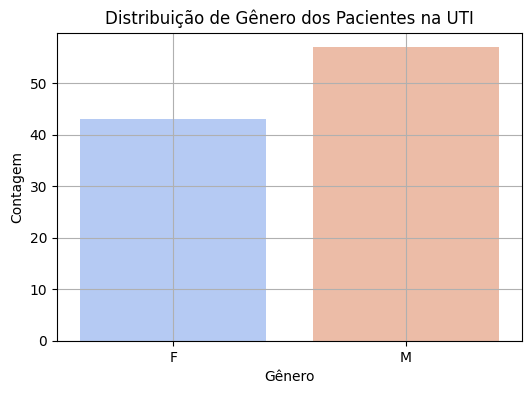

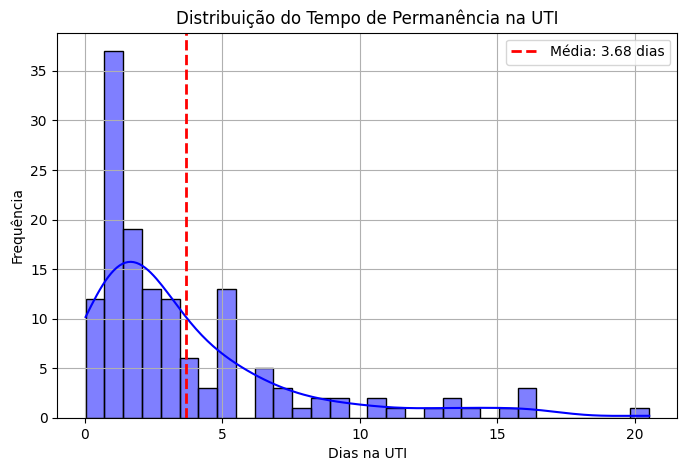

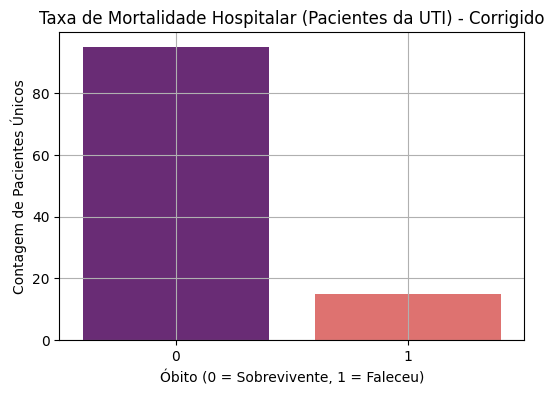

In [3]:
# üìä Distribui√ß√£o de G√™nero
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=patients_df, hue='gender', palette="coolwarm", legend=False)
plt.xlabel("G√™nero")
plt.ylabel("Contagem")
plt.title("Distribui√ß√£o de G√™nero dos Pacientes na UTI")
plt.grid(True)
plt.savefig("distribuicao_genero_uti.png", dpi=300)
plt.show()

# üìä **Melhoria: Distribui√ß√£o do Tempo M√©dio de Interna√ß√£o na UTI com Linha de M√©dia**
plt.figure(figsize=(8, 5))
sns.histplot(icustays_df['icu_los'].dropna(), bins=30, kde=True, color="blue")
plt.axvline(tempo_medio_uti, color='red', linestyle='dashed', linewidth=2, label=f'M√©dia: {tempo_medio_uti:.2f} dias')
plt.xlabel("Dias na UTI")
plt.ylabel("Frequ√™ncia")
plt.title("Distribui√ß√£o do Tempo de Perman√™ncia na UTI")
plt.legend()
plt.grid(True)
plt.savefig("tempo_medio_internacao_uti.png", dpi=300)
plt.show()

# üìä **Taxa de Mortalidade Hospitalar (Apenas Pacientes da UTI) - Corrigido**
plt.figure(figsize=(6, 4))
sns.countplot(x='hospital_expire_flag', data=mortalidade_uti_corrigida, hue='hospital_expire_flag', palette="magma", legend=False)
plt.xlabel("√ìbito (0 = Sobrevivente, 1 = Faleceu)")
plt.ylabel("Contagem de Pacientes √önicos")
plt.title("Taxa de Mortalidade Hospitalar (Pacientes da UTI) - Corrigido")
plt.grid(True)
plt.savefig("mortalidade_uti.png", dpi=300)
plt.show()


üìä **Compara√ß√£o de Mortalidade entre Pacientes que Usaram e N√£o Usaram Vasopressores**

            Grupo  N√∫mero de Pacientes  √ìbitos  Taxa de Mortalidade (%)
Com Vasopressores                   53      12                22.641509
Sem Vasopressores                   47       3                 6.382979


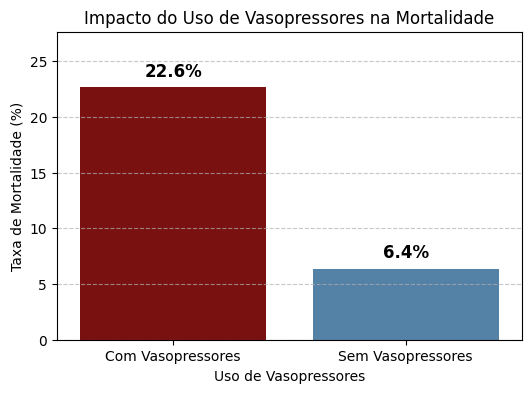


‚úÖ **An√°lise Final: Impacto das Comorbidades no Uso de Vasopressores**

C√≥digo ICD  N√∫mero de Pacientes com Comorbidade  Pacientes com Vasopressores  % Pacientes com Vasopressores                                                                                   Descri√ß√£o da Comorbidade
     42731                                   18                           12                      66.666667                                                                                        Atrial fibrillation
      2859                                   18                           12                      66.666667                                                                                        Anemia, unspecified
      E785                                   21                           14                      66.666667                                                                                Hyperlipidemia, unspecified
     41401                                   19              

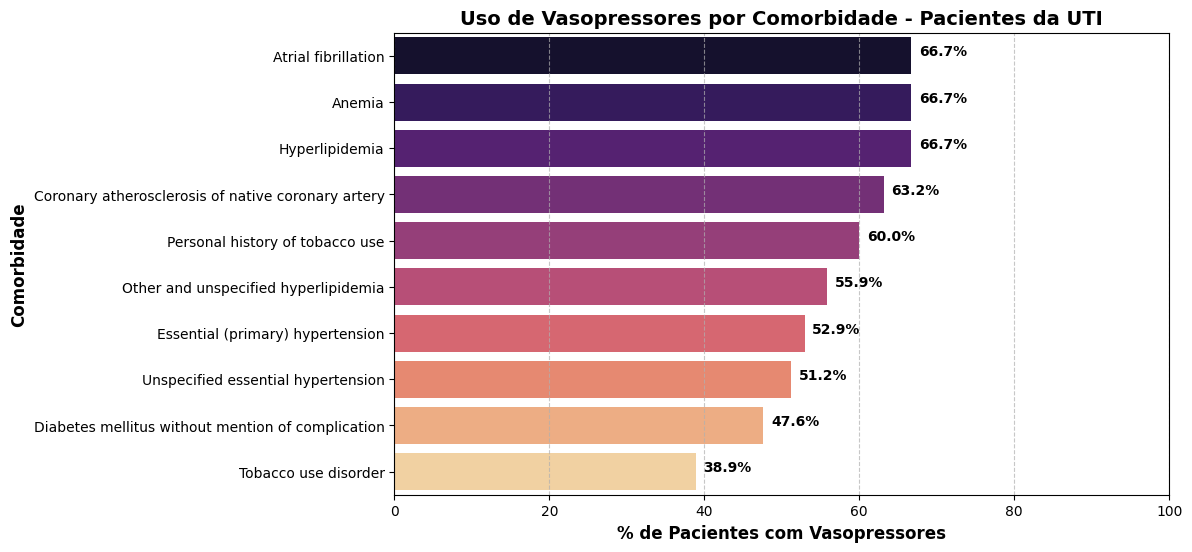

In [4]:
import seaborn as sns

# üìå Carregar os dados
prescriptions_df = pd.read_csv("prescriptions.csv")

# üìå Lista de Vasopressores de Interesse
vasopressores = ["dopamine", "epinephrine", "norepinephrine", "phenylephrine", "vasopressin"]

# üìå Filtrar pacientes que receberam vasopressores
pacientes_vasopressores = prescriptions_df[prescriptions_df['drug'].str.contains('|'.join(vasopressores), case=False, na=False)]
num_pacientes_vasopressores = pacientes_vasopressores['subject_id'].nunique()

# üìå Criar grupos de pacientes
pacientes_sem_vasopressores = pacientes_uti[~pacientes_uti["subject_id"].isin(pacientes_vasopressores["subject_id"])]
num_pacientes_sem_vasopressores = pacientes_sem_vasopressores['subject_id'].nunique()

# üìå Contar √≥bitos nos dois grupos
num_obitos_vasopressores = pacientes_vasopressores.merge(
    pacientes_uti[['subject_id', 'hospital_expire_flag']], on="subject_id", how="left"
)
num_obitos_vasopressores = num_obitos_vasopressores[num_obitos_vasopressores['hospital_expire_flag'] == 1]['subject_id'].nunique()
num_obitos_sem_vasopressores = pacientes_sem_vasopressores[pacientes_sem_vasopressores['hospital_expire_flag'] == 1]['subject_id'].nunique()

# üìå Calcular taxas de mortalidade
taxa_mortalidade_vasopressores = (num_obitos_vasopressores / num_pacientes_vasopressores) * 100
taxa_mortalidade_sem_vasopressores = (num_obitos_sem_vasopressores / num_pacientes_sem_vasopressores) * 100

# üìå Criar DataFrame de compara√ß√£o
tabela_mortalidade = pd.DataFrame({
    "Grupo": ["Com Vasopressores", "Sem Vasopressores"],
    "N√∫mero de Pacientes": [num_pacientes_vasopressores, num_pacientes_sem_vasopressores],
    "√ìbitos": [num_obitos_vasopressores, num_obitos_sem_vasopressores],
    "Taxa de Mortalidade (%)": [taxa_mortalidade_vasopressores, taxa_mortalidade_sem_vasopressores]
})
print("\nüìä **Compara√ß√£o de Mortalidade entre Pacientes que Usaram e N√£o Usaram Vasopressores**\n")
print(tabela_mortalidade.to_string(index=False))

# üìå Criar gr√°fico de impacto dos vasopressores na mortalidade
plt.figure(figsize=(6, 4))
sns.barplot(x="Grupo", y="Taxa de Mortalidade (%)", hue="Grupo", data=tabela_mortalidade, palette=["darkred", "steelblue"], legend=False)
plt.ylabel("Taxa de Mortalidade (%)")
plt.xlabel("Uso de Vasopressores")
plt.title("Impacto do Uso de Vasopressores na Mortalidade")
plt.ylim(0, max(tabela_mortalidade["Taxa de Mortalidade (%)"]) + 5)
for i, row in tabela_mortalidade.iterrows():
    plt.text(i, row["Taxa de Mortalidade (%)"] + 1, f"{row['Taxa de Mortalidade (%)']:.1f}%", ha='center', fontsize=12, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("impacto_vasopressores_mortalidade.png", dpi=300)
plt.show()

# üìå An√°lise de comorbidades
diagnoses_uti_filtrado = diagnoses_uti[diagnoses_uti["icd_code"].isin(["4019", "2724", "E785", "25000", "V1582", "41401", "3051", "2859", "42731", "I10"])]
uso_por_comorbidade = diagnoses_uti_filtrado.groupby("icd_code")["subject_id"].nunique().reset_index()
uso_por_comorbidade.columns = ["C√≥digo ICD", "N√∫mero de Pacientes com Comorbidade"]

uso_vasopressores_comorbidade = diagnoses_uti_filtrado.merge(
    pacientes_vasopressores[['subject_id']], on="subject_id", how="inner"
).groupby("icd_code")["subject_id"].nunique().reset_index()
uso_vasopressores_comorbidade.columns = ["C√≥digo ICD", "Pacientes com Vasopressores"]

impacto_comorbidade = uso_por_comorbidade.merge(uso_vasopressores_comorbidade, on="C√≥digo ICD", how="left")
impacto_comorbidade["Pacientes com Vasopressores"] = impacto_comorbidade["Pacientes com Vasopressores"].fillna(0)
impacto_comorbidade["% Pacientes com Vasopressores"] = (
    impacto_comorbidade["Pacientes com Vasopressores"] / impacto_comorbidade["N√∫mero de Pacientes com Comorbidade"]
) * 100

impacto_comorbidade = impacto_comorbidade.merge(
    icd_descriptions_df[['icd_code', 'long_title']], left_on="C√≥digo ICD", right_on="icd_code", how="left"
).drop(columns=["icd_code"])
impacto_comorbidade.rename(columns={"long_title": "Descri√ß√£o da Comorbidade"}, inplace=True)
impacto_comorbidade.sort_values(by="% Pacientes com Vasopressores", ascending=False, inplace=True)

print("\n‚úÖ **An√°lise Final: Impacto das Comorbidades no Uso de Vasopressores**\n")
print(impacto_comorbidade.to_string(index=False))
impacto_comorbidade.to_csv("impacto_vasopressores_comorbidades.csv", index=False)

# üìä **Criar Gr√°fico de Uso de Vasopressores por Comorbidade**
plt.figure(figsize=(10, 6))
sns.barplot(
    x=impacto_comorbidade["% Pacientes com Vasopressores"],
    y=impacto_comorbidade["Descri√ß√£o da Comorbidade"].str.split(',').str[0],  # Reduzindo nomes longos
    hue=impacto_comorbidade["Descri√ß√£o da Comorbidade"],  # Atribuir hue
    palette="magma",
    legend=False  # Remover legenda duplicada
)

# üìå Melhorar a formata√ß√£o do gr√°fico
plt.xlabel("% de Pacientes com Vasopressores", fontsize=12, fontweight='bold')
plt.ylabel("Comorbidade", fontsize=12, fontweight='bold')
plt.title("Uso de Vasopressores por Comorbidade - Pacientes da UTI", fontsize=14, fontweight='bold')
plt.xlim(0, 100)  # O limite m√°ximo √© 100%
plt.grid(axis="x", linestyle="--", alpha=0.7)

# üìå Adicionar valores no topo das barras
for i, row in enumerate(impacto_comorbidade["% Pacientes com Vasopressores"]):
    plt.text(row + 1, i, f"{row:.1f}%", ha="left", fontsize=10, fontweight="bold", color="black")

# üìå Salvar e mostrar o gr√°fico aprimorado
plt.savefig("uso_vasopressores_por_comorbidade.png", dpi=300)
plt.show()



1Ô∏è‚É£ Importa√ß√£o de Bibliotecas
üìå Carregue todas as bibliotecas necess√°rias.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


üìä **Compara√ß√£o de Mortalidade entre Pacientes com e sem Ventila√ß√£o Mec√¢nica**

                  Grupo  N√∫mero de Pacientes  √ìbitos  Taxa de Mortalidade (%)
Com Ventila√ß√£o Mec√¢nica                   55      13                23.636364
Sem Ventila√ß√£o Mec√¢nica                   45       2                 4.444444


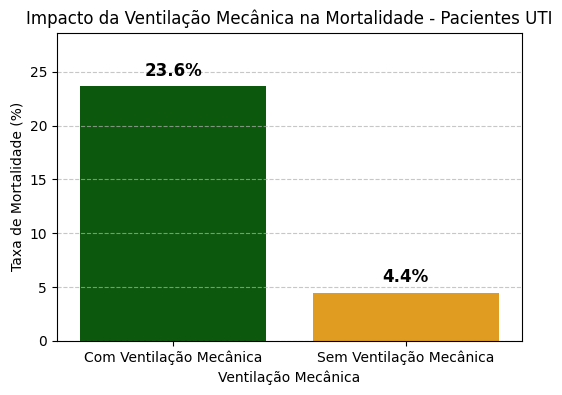

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# üìå Carregar dados
procedureevents_df = pd.read_csv("procedureevents.csv")
pacientes_uti = pd.read_csv("admissions.csv")

# üìå Filtrar procedimentos de ventila√ß√£o mec√¢nica
ventilacao_df = procedureevents_df[procedureevents_df['ordercategoryname'].str.contains("Ventilation", case=False, na=False)]
pacientes_ventilacao = ventilacao_df[['subject_id']].drop_duplicates()
pacientes_ventilacao['ventilacao'] = 1

# üìå Criar coluna de ventila√ß√£o no admissions
pacientes_uti = pacientes_uti.merge(pacientes_ventilacao, on='subject_id', how='left')
pacientes_uti['ventilacao'] = pacientes_uti['ventilacao'].fillna(0)

# üìå Separar os dois grupos
grupo_com_ventilacao = pacientes_uti[pacientes_uti['ventilacao'] == 1]
grupo_sem_ventilacao = pacientes_uti[pacientes_uti['ventilacao'] == 0]

# üìå Contar √≥bitos nos dois grupos
num_pacientes_ventilacao = grupo_com_ventilacao['subject_id'].nunique()
num_obitos_ventilacao = grupo_com_ventilacao[grupo_com_ventilacao['hospital_expire_flag'] == 1]['subject_id'].nunique()

num_pacientes_sem_ventilacao = grupo_sem_ventilacao['subject_id'].nunique()
num_obitos_sem_ventilacao = grupo_sem_ventilacao[grupo_sem_ventilacao['hospital_expire_flag'] == 1]['subject_id'].nunique()

# üìå Calcular taxas de mortalidade
taxa_mortalidade_ventilacao = (num_obitos_ventilacao / num_pacientes_ventilacao) * 100
taxa_mortalidade_sem_ventilacao = (num_obitos_sem_ventilacao / num_pacientes_sem_ventilacao) * 100

# üìå Criar DataFrame de compara√ß√£o
tabela_mortalidade_ventilacao = pd.DataFrame({
    "Grupo": ["Com Ventila√ß√£o Mec√¢nica", "Sem Ventila√ß√£o Mec√¢nica"],
    "N√∫mero de Pacientes": [num_pacientes_ventilacao, num_pacientes_sem_ventilacao],
    "√ìbitos": [num_obitos_ventilacao, num_obitos_sem_ventilacao],
    "Taxa de Mortalidade (%)": [taxa_mortalidade_ventilacao, taxa_mortalidade_sem_ventilacao]
})

print("\nüìä **Compara√ß√£o de Mortalidade entre Pacientes com e sem Ventila√ß√£o Mec√¢nica**\n")
print(tabela_mortalidade_ventilacao.to_string(index=False))

# üìå Criar gr√°fico
plt.figure(figsize=(6, 4))
sns.barplot(x="Grupo", y="Taxa de Mortalidade (%)", hue="Grupo", data=tabela_mortalidade_ventilacao, palette=["darkgreen", "orange"], legend=False)
plt.ylabel("Taxa de Mortalidade (%)")
plt.xlabel("Ventila√ß√£o Mec√¢nica")
plt.title("Impacto da Ventila√ß√£o Mec√¢nica na Mortalidade - Pacientes UTI")
plt.ylim(0, max(tabela_mortalidade_ventilacao["Taxa de Mortalidade (%)"]) + 5)
for i, row in tabela_mortalidade_ventilacao.iterrows():
    plt.text(i, row["Taxa de Mortalidade (%)"] + 1, f"{row['Taxa de Mortalidade (%)']:.1f}%", ha='center', fontsize=12, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("impacto_ventilacao_mortalidade.png", dpi=300)
plt.show()

